In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import statsmodels.formula.api as smf
from scipy import stats

plt.style.use('seaborn-v0_8-poster')


In [2]:
def significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


def _draw_sig_line(ax, x1, x2, y, text, h=0.03):
    """Draw a flipped (downward) significance bracket below bars."""
    ax.plot((x1, x1, x2, x2),
            (y, y - h, y - h, y),
            lw=1.5, color="black", clip_on=False)
    if text:
        ax.text((x1 + x2) / 2.0, y - h * 1.2, text,
                ha="center", va="top",
                fontsize=14, fontweight="bold", color="black")


def get_matching_model_terms(model, variable):
    """
    Return model term names from model.params.index that match `variable`.

    Behavior:
    ----------
    - If `variable` has no ':' or '*' → return only main-effect terms
      (e.g., 'Group' → ['Group[T.HC]'])
    - If `variable` includes ':' or '*' → return exact interaction terms
      (e.g., 'Group:Drug' → ['Group[T.HC]:Drug[T.Placebo]'])
    - If `variable` == 'two_way' → return *all* 2-way interactions
      (useful in 3-factor models like Group * Drug * Gender)
    - If `variable` == 'three_way' → return *all* 3-way interactions

    Example model.params.index:
      ['Intercept',
       'Group[T.HC]',
       'Drug[T.Placebo]',
       'Gender[T.Female]',
       'Group[T.HC]:Drug[T.Placebo]',
       'Group[T.HC]:Gender[T.Female]',
       'Drug[T.Placebo]:Gender[T.Female]',
       'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]']
    """
    # Remove intercept
    params = [p for p in model.params.index if p.lower() != "intercept"]

    # === Case 1: Request all 2-way interactions ===
    if variable.lower() == "two_way":
        return [p for p in params if p.count(":") == 1]

    # === Case 2: Request all 3-way interactions ===
    if variable.lower() == "three_way":
        return [p for p in params if p.count(":") == 2]

    # === Case 3: Single factor → main effects only ===
    if (":" not in variable) and ("*" not in variable):
        factor = variable
        return [p for p in params if p.startswith(factor + "[") and (":" not in p)]

    # === Case 4: Specific interaction (2-way or 3-way) ===
    var = variable.replace("*", ":")
    factors = [f for f in var.split(":") if f]

    out = []
    for p in params:
        # must have correct interaction order
        if p.count(":") != (len(factors) - 1):
            continue
        # must include all specified factors
        if all((f + "[") in p for f in factors):
            out.append(p)

    return out



def extract_factors_from_term(term):
    """
    Extract base factor names (e.g., 'Group', 'Drug', 'Gender') 
    from a statsmodels term like:
        'Group[T.HC]:Drug[T.Placebo]'  → ['Group', 'Drug']
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
        'Group[T.HC]' → ['Group']

    Works for both main and interaction terms.
    """
    # Split by ':' to separate interaction components
    parts = term.split(":")
    # For each part, take everything before the first '['
    factors = [p.split("[")[0] for p in parts]
    return factors

In [3]:
def add_sig_stars(ax, df, roi_list, variable, pad_frac=0.1, hue_order=None):
    """
    Generalized version that supports 2-way, 3-way, or higher-order interactions.

    Prints:
      1. Model result (ROI, variable, β, t, df, p)
      2. One-sample t-tests (ROI, factor level, mean, t, df, p)
    Adds * to bar plot for significant results.

    Automatically reads model factors from 'variable'.
    e.g. variable='Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → model='Z_score ~ Group * Drug * Gender'
    """

    ymin, ymax = ax.get_ylim()
    y_range = ymax - ymin
    is_interaction = ":" in variable

    # === Parse model factors dynamically ===
    # Example: 'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors) + ("" if "guess" in factors else " + guess")


    print(f"\nModel results ({formula})")
    print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
    print("-" * 100)

    # === Table 1: Model results ===
    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # 🔹 Dynamically specified model
        model = smf.ols(formula, data=df_roi).fit()

        if variable not in model.params.index:
            continue

        beta = model.params[variable]
        tval = model.tvalues[variable]
        pval = model.pvalues[variable]
        dfree = int(model.df_resid)
        star = significance_marker(pval)

        print(f"{roi:<15} {variable:<50} {beta:>10.3f} {tval:>8.2f} {dfree:>5} {pval:>8.3f} {star:>5}")

        # --- Bar selection per ROI ---
        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]
        if not bars:
            continue

        # --- Draw flipped bracket for significant model effects (main effects only) ---
        if not is_interaction and star:
            bars_sorted = sorted(bars, key=lambda r: r.get_x())
            b1, b2 = bars_sorted[0], bars_sorted[-1]
            x1c = b1.get_x() + b1.get_width() / 2
            x2c = b2.get_x() + b2.get_width() / 2
            x_mid = (x1c + x2c) / 2
            y1 = b1.get_y() + b1.get_height()
            y2 = b2.get_y() + b2.get_height()
            min_y = min(y1, y2)
            y_bracket = min_y - 0.3
            y_star = min_y - 0.4
            _draw_sig_line(ax, x1c, x2c, y_bracket, "", h=y_range * 0.03)
            ax.text(x_mid, y_star, star,
                    ha="center", va="top",
                    fontsize=14, fontweight="bold", color="black")

    print("-" * 100)

    # === Table 2: One-sample t-tests ===
    if is_interaction:
        group_factors = factors
        print(f"ONE-SAMPLE T-TESTS BY INTERACTION LEVEL ({' × '.join(group_factors)})")
    else:
        group_factors = [factors[0]]
        print(f"ONE-SAMPLE T-TESTS BY {group_factors[0].upper()} LEVEL")

    print(f"{'ROI':<15} {'Level':<50} {'Mean':>10} {'t':>8} {'df':>6} {'p':>10} {'Sig':>5}")
    print("-" * 100)

    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]

        # === Main effect ===
        if len(group_factors) == 1:
            factor = group_factors[0]
            if factor not in df_roi.columns:
                continue

            for level, vals in df_roi.groupby(factor, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                label = f"{factor}={level}"
                print(f"{roi:<15} {label:<50} {mean_val:>10.3f} {tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    if hue_order is None:
                        hue_order = list(df[factor].cat.categories)
                    level_to_bar = dict(zip(hue_order, bars))
                    if level in level_to_bar:
                        rect = level_to_bar[level]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

        # === Interaction effect (2-way, 3-way, or higher) ===
        else:
            valid_factors = [f for f in group_factors if f in df_roi.columns]
            if len(valid_factors) < 2:
                continue

            for levels, vals in df_roi.groupby(valid_factors, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                level_labels = "_".join(map(str, levels))
                print(f"{roi:<15} {level_labels:<50} {mean_val:>10.3f} "
                      f"{tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    # Build hue order dynamically based on unique combinations
                    if hue_order is None:
                        hue_order = [
                            "_".join(map(str, combo))
                            for combo in df_roi[valid_factors]
                            .drop_duplicates()
                            .itertuples(index=False, name=None)
                        ]
                    level_to_bar = dict(zip(hue_order, bars))
                    key = "_".join(map(str, levels))
                    if key in level_to_bar:
                        rect = level_to_bar[key]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

    print("-" * 100)


In [4]:
def add_sig_stars_lineplot_interaction(ax, df, roi_list, variable):
    """
    Adds significance stars (***, **, *) to each subplot's title
    if the specified interaction term in `variable` is significant
    for that ROI.

    Automatically supports 2-way, 3-way, or higher-order interactions.
    e.g.:
        'Group[T.HC]:Gender[T.Female]'
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]'
    """

    # Extract main factors from variable (remove duplicates safely)
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors) + ("" if "guess" in factors else " + guess")

    axes = ax.flat if hasattr(ax, "flat") else [ax]

    print(f"\n=== Lineplot significance check for {variable} ===")
    print(f"Model formula: {formula}")
    print(f"{'ROI':<15} {'p-value':>10} {'Sig':>5}")
    print("-" * 35)

    for i, roi in enumerate(roi_list):
        if i >= len(axes):
            break
        ax_i = axes[i]

        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # Dynamically fit model with all relevant factors
        model = smf.ols(formula, data=df_roi).fit()

        # Skip if the term is not part of the model
        if variable not in model.pvalues.index:
            continue

        # Get p-value and significance marker
        pval = model.pvalues[variable]
        star = significance_marker(pval)

        # Update subplot title with star if significant
        current_title = ax_i.get_title()
        new_title = f"{current_title} {star}" if star else current_title
        ax_i.set_title(new_title, fontweight="bold" if star else "normal")

        print(f"{roi:<15} {pval:>10.4f} {star:>5}")

    print("-" * 35)


In [5]:
tasks = ['phase2','phase3']
contrast_list = [
        "CSR-CSS",   
        "CSR-CS-",
        "CSS-CS-",
        "CSR-fix", 
        "CSS-fix",   
        "CSminus-fix"
        ]
ROI_list = [
        'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
        'VMPFC'
        ]
group_list = [
        'Patient',
        'HC'
        ]
drug_list = ['Oxytocin',
        'Placebo']
gender_list = ['Male', 'Female']

In [6]:
plot_dir_top = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI/plots/model-guess_motion-removeFD0.5'
drug_order_file = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/source_data/behav/drug_order.xlsx'
df_drug_order = pd.read_excel(drug_order_file, 'drug_order')
first_level_dir = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI'
first_level_data_file = os.path.join(first_level_dir, 'first_level_motion-removeFD0.5.csv')
df_fMRI = pd.read_csv(first_level_data_file)
df_merged = pd.merge(df_fMRI, df_drug_order, on='subID', how='left')
df_all = df_merged.rename(columns={
    'Task': 'Phase'
})
df_all.loc[df_all['subID'].str.startswith('N1'), 'Group'] = 'Patient'
df_all.loc[df_all['subID'].str.startswith('N2'), 'Group'] = 'HC'
categorical_cols = ['ROI', 'subID', 'Phase', 'Contrast', 'Group', 'Gender', 'Drug','guess']
df_all[categorical_cols] = df_all[categorical_cols].astype('category')
df_all['Contrast'] = df_all['Contrast'].cat.set_categories(contrast_list, ordered=True)
df_all['ROI'] = df_all['ROI'].cat.set_categories(ROI_list, ordered=True)
df_all['Group'] = df_all['Group'].cat.set_categories(group_list, ordered=True)
df_all['Drug'] = df_all['Drug'].cat.set_categories(drug_list, ordered=True)
df_all['Gender'] = df_all['Gender'].cat.set_categories(gender_list, ordered=True)


In [7]:
print(len(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID'].unique()))
print(len(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID'].unique()))
print(len(df_drug_order['subID'].unique()))

100
101
104


In [8]:
# Subjects in drug order but missing from fMRI data
missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase2: {len(missing_in_fMRI)}")
print(missing_in_fMRI)

missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase3: {len(missing_in_fMRI)}")
print(missing_in_fMRI)
# SUBJECTS_NO_MRI = {
#     'phase2': ['N102', 'N208'],
#     'phase3': ['N102', 'N208', 'N120']
# }
# removing subjects w wrong sequence / missing phases:
# sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
# sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3



🧩 Subjects in drug order file but not in fMRI data in phase2: 4
['N101' 'N102' 'N201' 'N208']
🧩 Subjects in drug order file but not in fMRI data in phase3: 3
['N102' 'N120' 'N208']


Reinstatement

placebo 

In [9]:
plot_dir = os.path.join(plot_dir_top, 'reinstatement/placebo')
os.makedirs(plot_dir, exist_ok=True)
model = smf.ols("Z_score ~ Group * Gender", data=df_all).fit()


===== Group main effect: CSR-CSS =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.428     1.25    47    0.218      
Insula          Group[T.HC]                                             0.126     0.35    47    0.730      
Hippocampus     Group[T.HC]                                             0.464     1.31    47    0.195      
ACC             Group[T.HC]                                             0.183     0.52    47    0.609      
VMPFC           Group[T.HC]                                             0.601     1.47    47    0.147      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

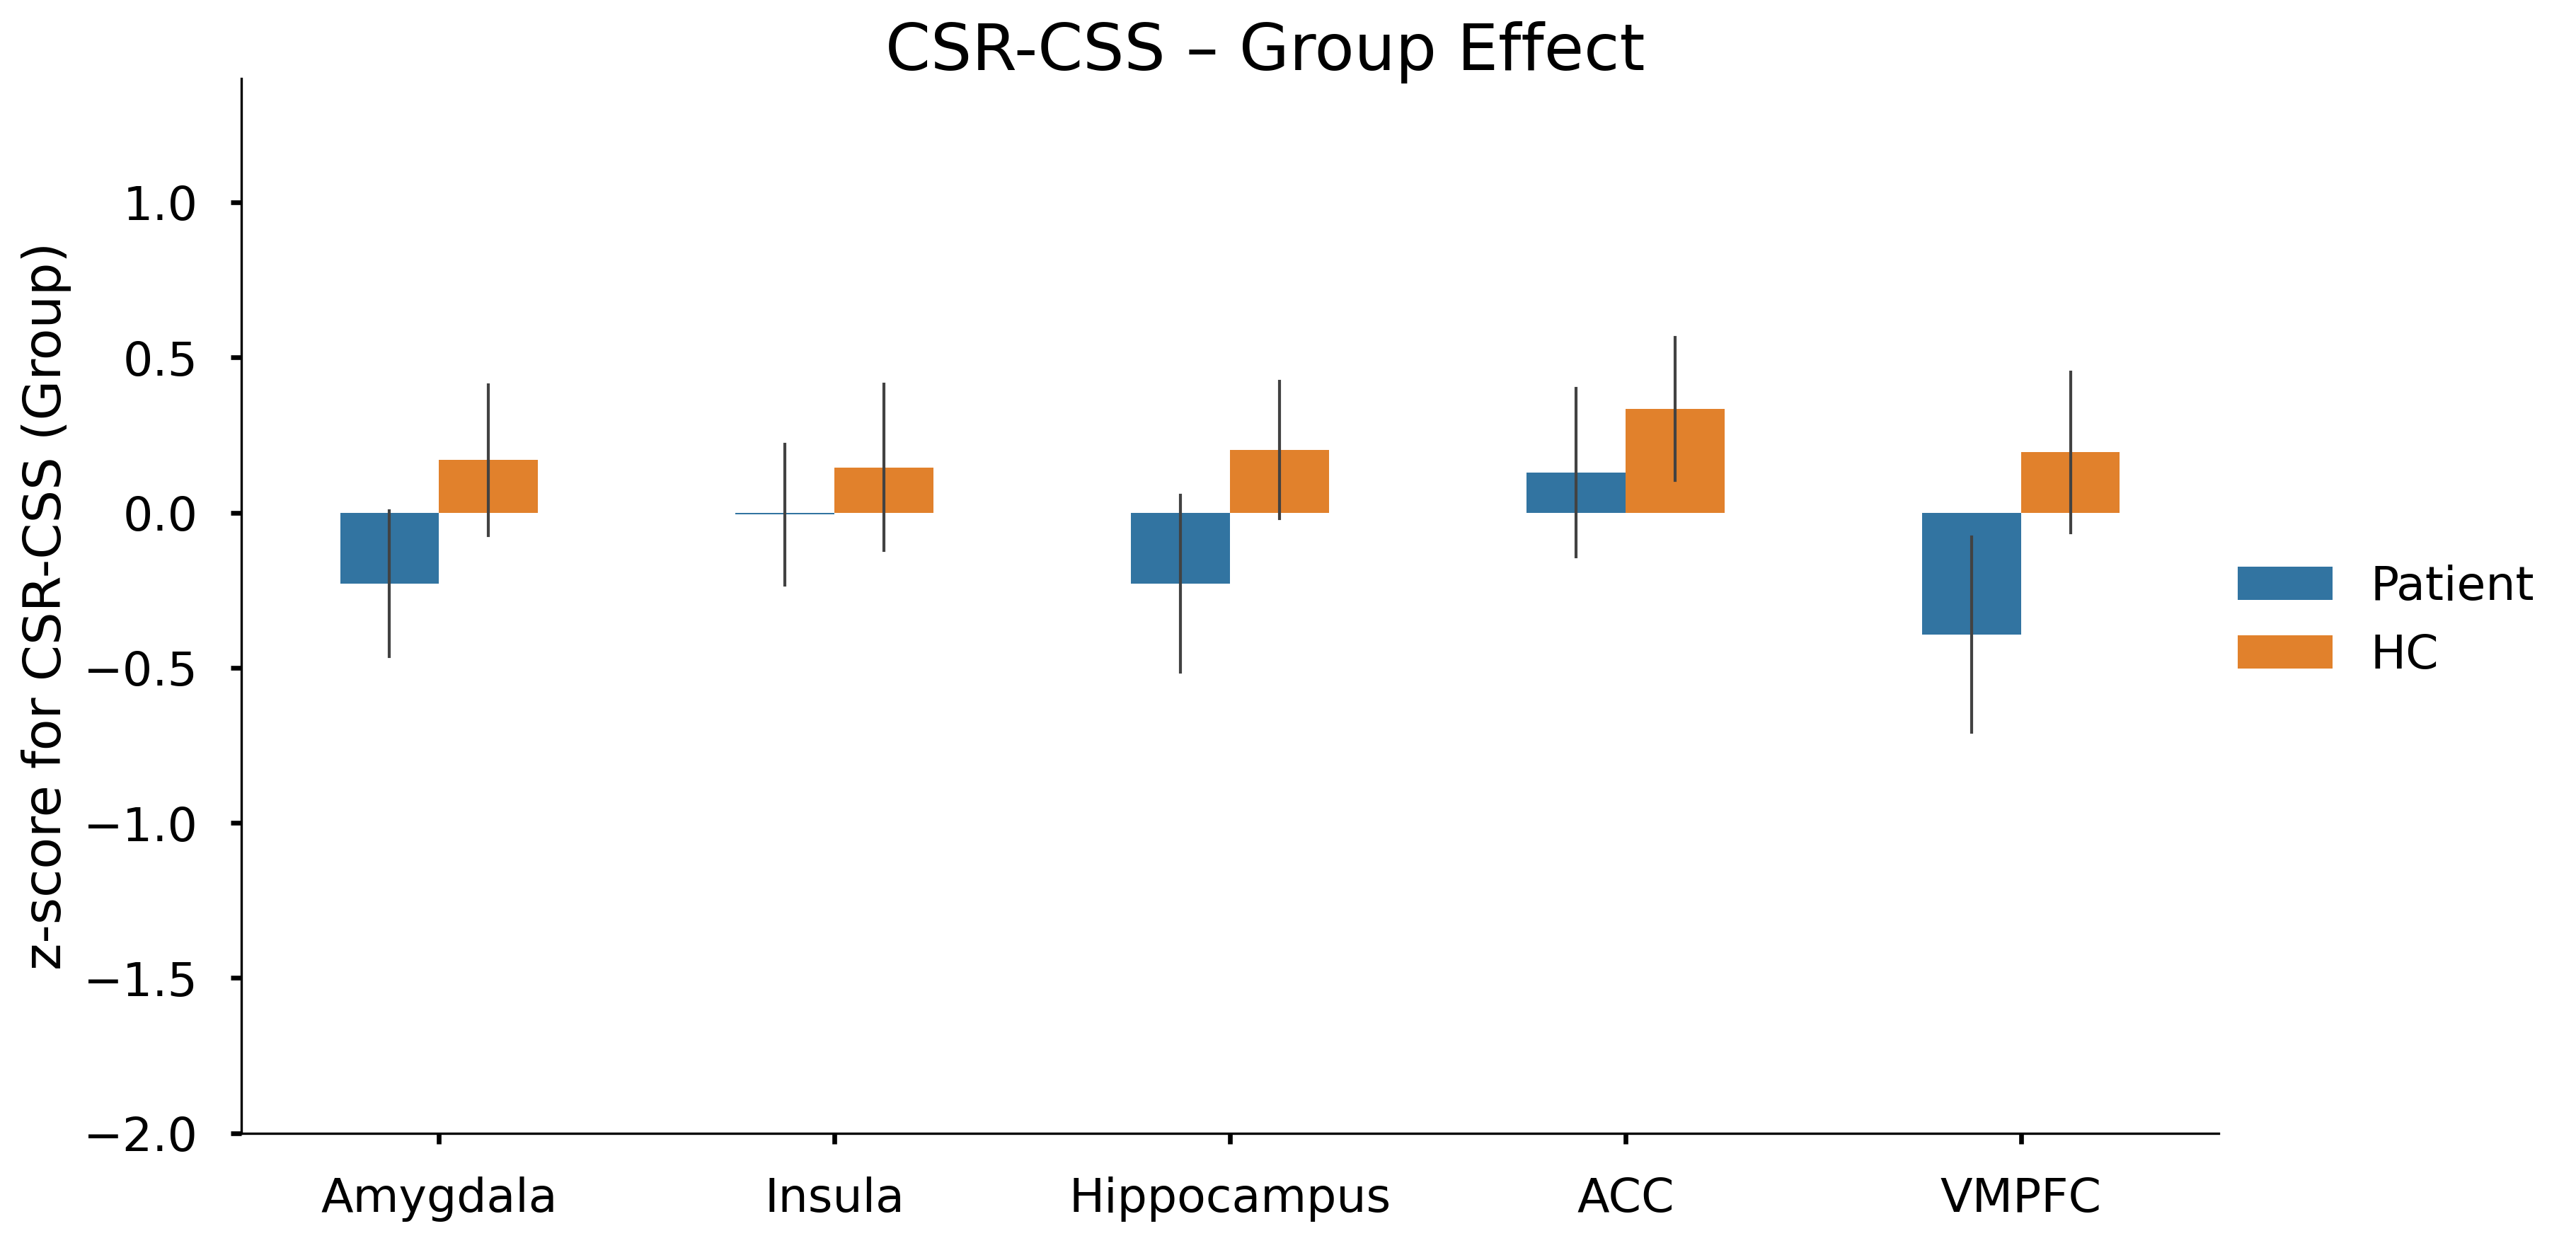


===== Group main effect: CSR-CS- =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.228     0.58    47    0.564      
Insula          Group[T.HC]                                             0.034     0.09    47    0.928      
Hippocampus     Group[T.HC]                                             0.037     0.10    47    0.923      
ACC             Group[T.HC]                                             0.102     0.25    47    0.801      
VMPFC           Group[T.HC]                                             0.098     0.25    47    0.802      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              


===== Group main effect: CSS-CS- =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.150    -0.40    47    0.688      
Insula          Group[T.HC]                                            -0.083    -0.24    47    0.809      
Hippocampus     Group[T.HC]                                            -0.377    -1.15    47    0.254      
ACC             Group[T.HC]                                            -0.063    -0.14    47    0.888      
VMPFC           Group[T.HC]                                            -0.461    -1.35    47    0.184      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

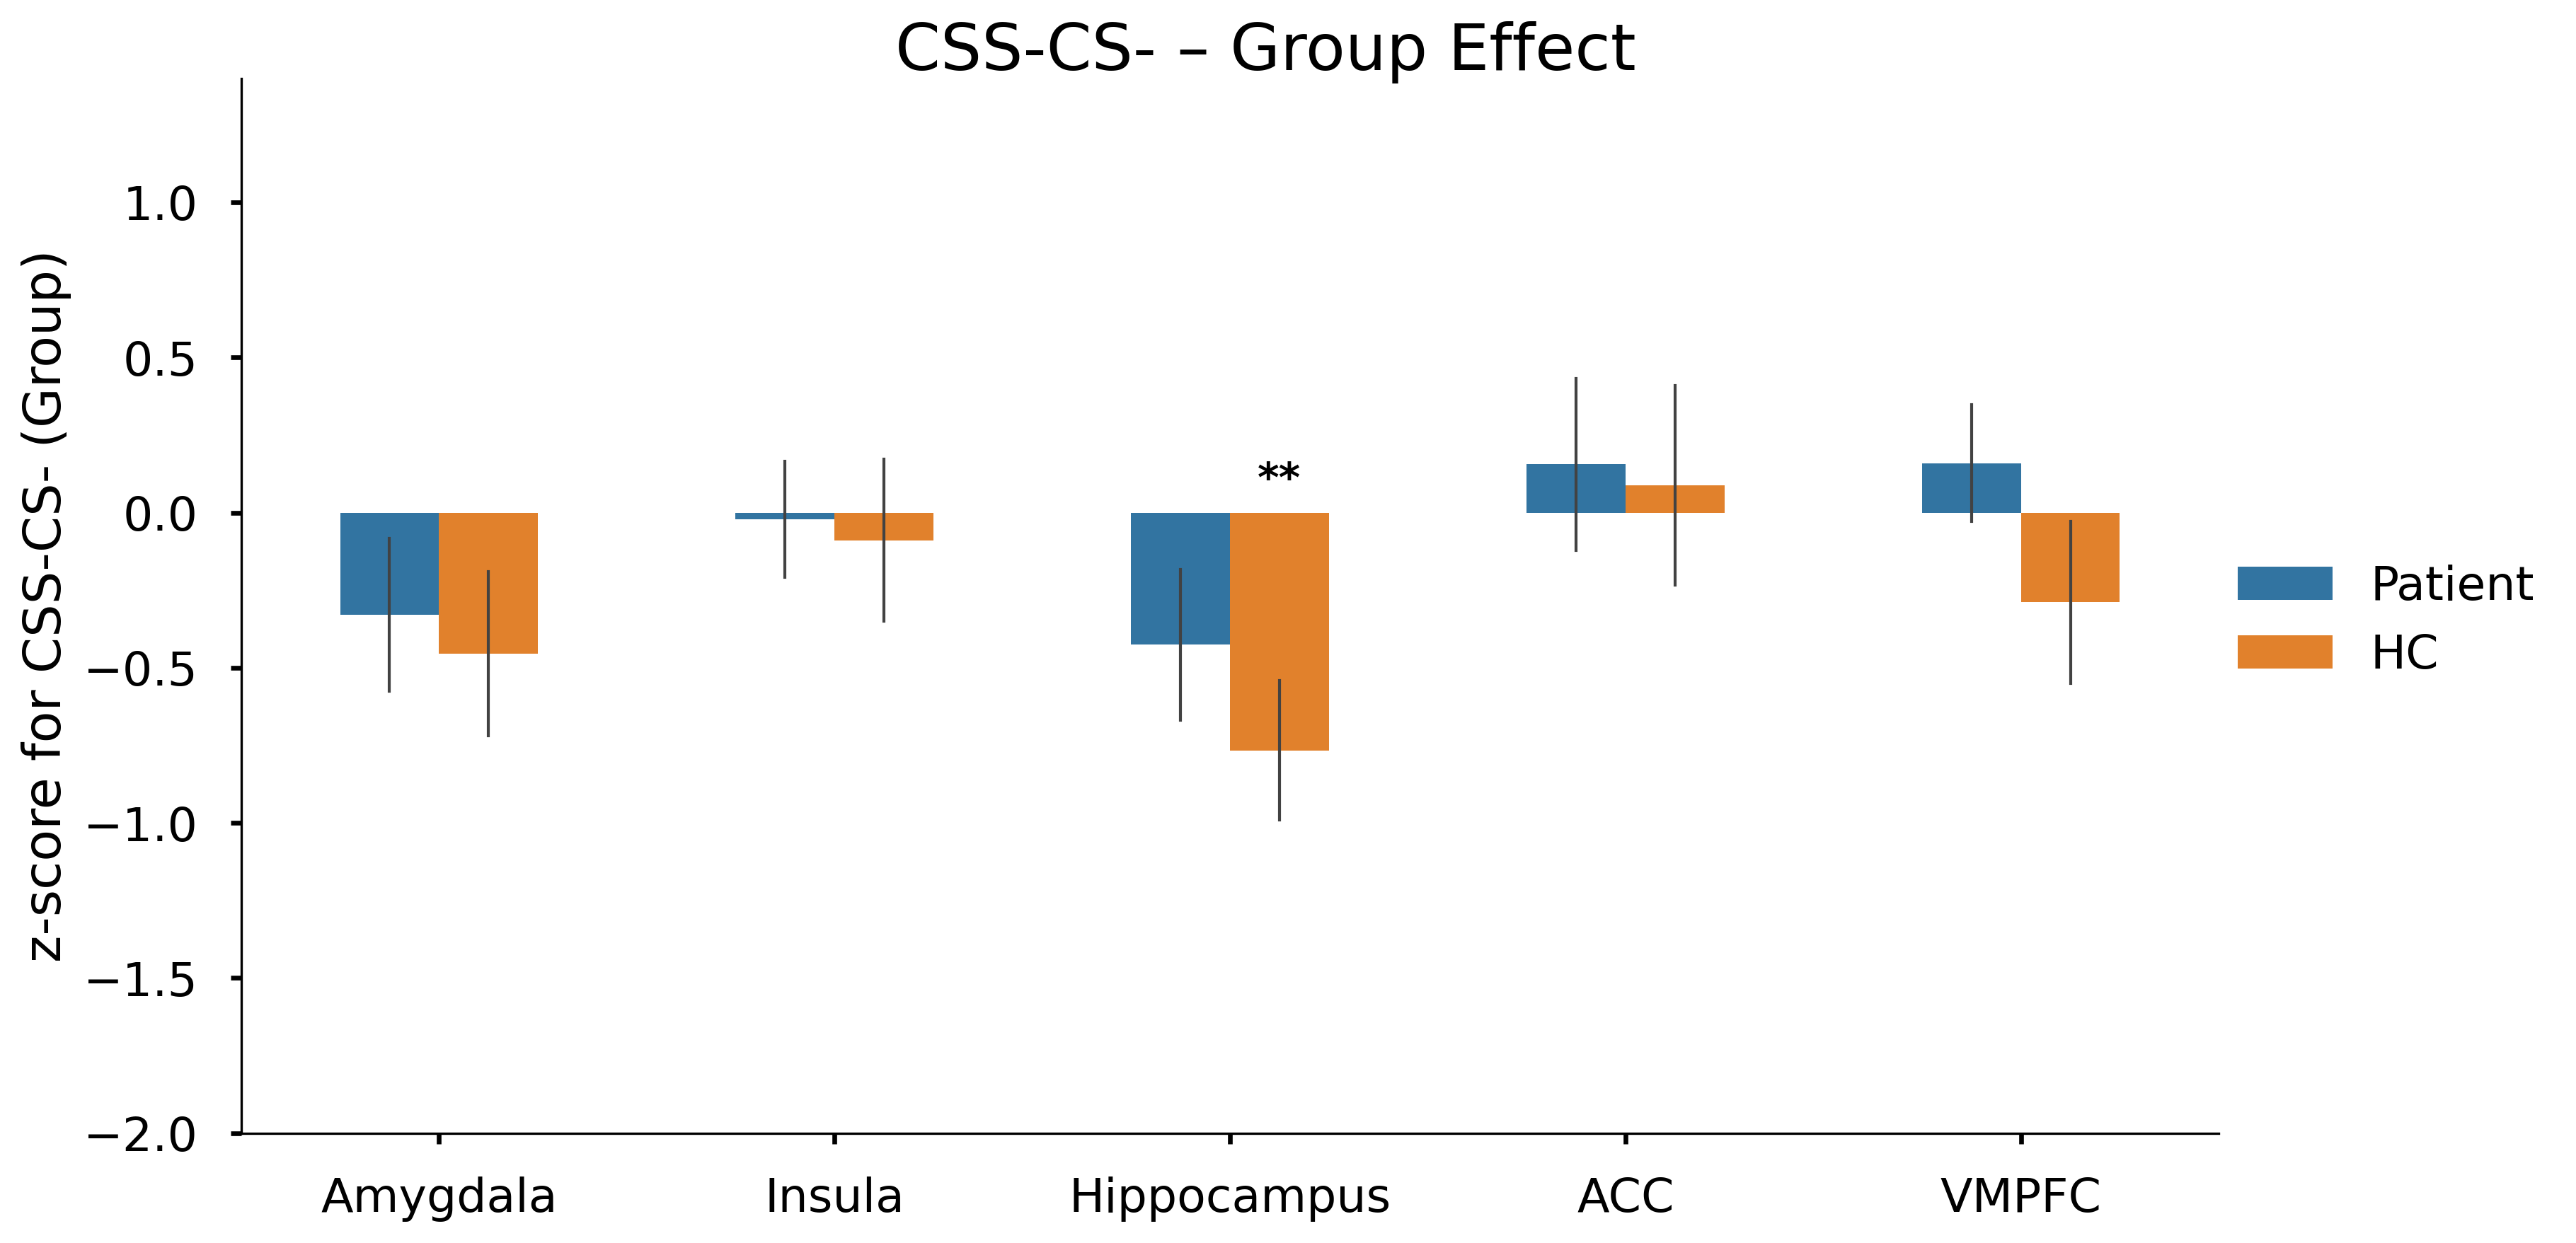


===== Group main effect: CSR-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.517     1.28    47    0.206      
Insula          Group[T.HC]                                             0.306     0.81    47    0.421      
Hippocampus     Group[T.HC]                                             0.059     0.16    47    0.874      
ACC             Group[T.HC]                                             0.302     0.87    47    0.386      
VMPFC           Group[T.HC]                                             0.511     1.27    47    0.210      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              


===== Group main effect: CSS-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.035    -0.09    47    0.930      
Insula          Group[T.HC]                                             0.128     0.37    47    0.710      
Hippocampus     Group[T.HC]                                            -0.532    -1.71    47    0.093      
ACC             Group[T.HC]                                             0.066     0.16    47    0.877      
VMPFC           Group[T.HC]                                            -0.253    -0.62    47    0.539      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

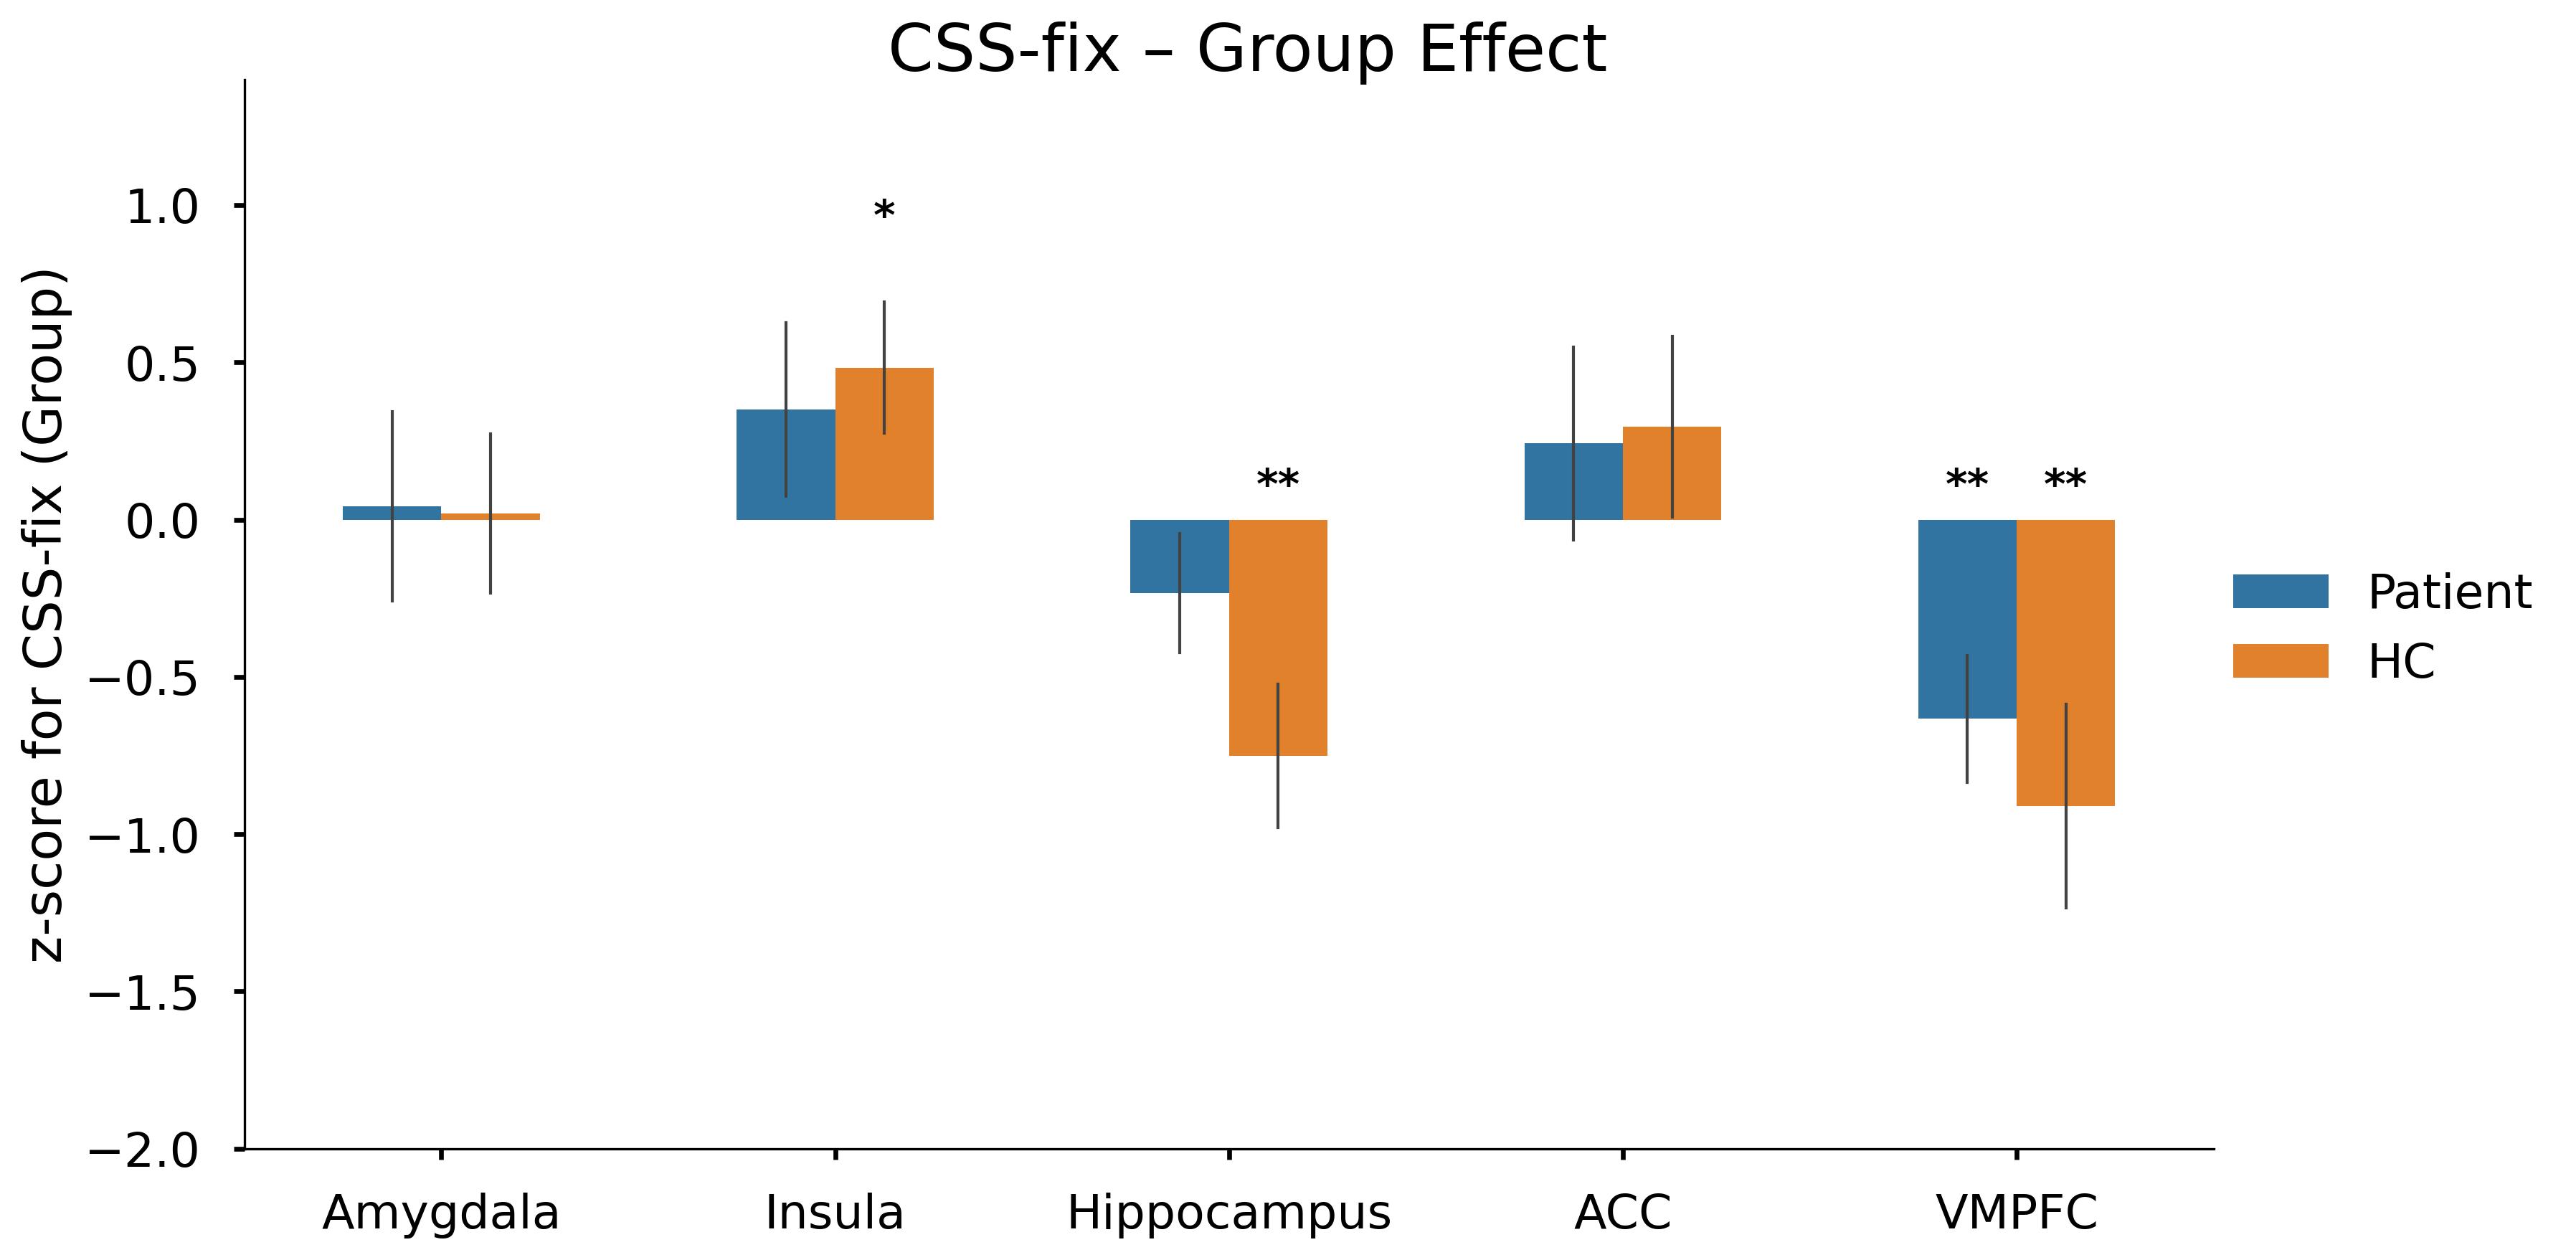


===== Group main effect: CSminus-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.172     0.43    47    0.668      
Insula          Group[T.HC]                                             0.224     0.58    47    0.564      
Hippocampus     Group[T.HC]                                            -0.013    -0.04    47    0.970      
ACC             Group[T.HC]                                             0.131     0.33    47    0.739      
VMPFC           Group[T.HC]                                             0.358     1.11    47    0.273      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level          

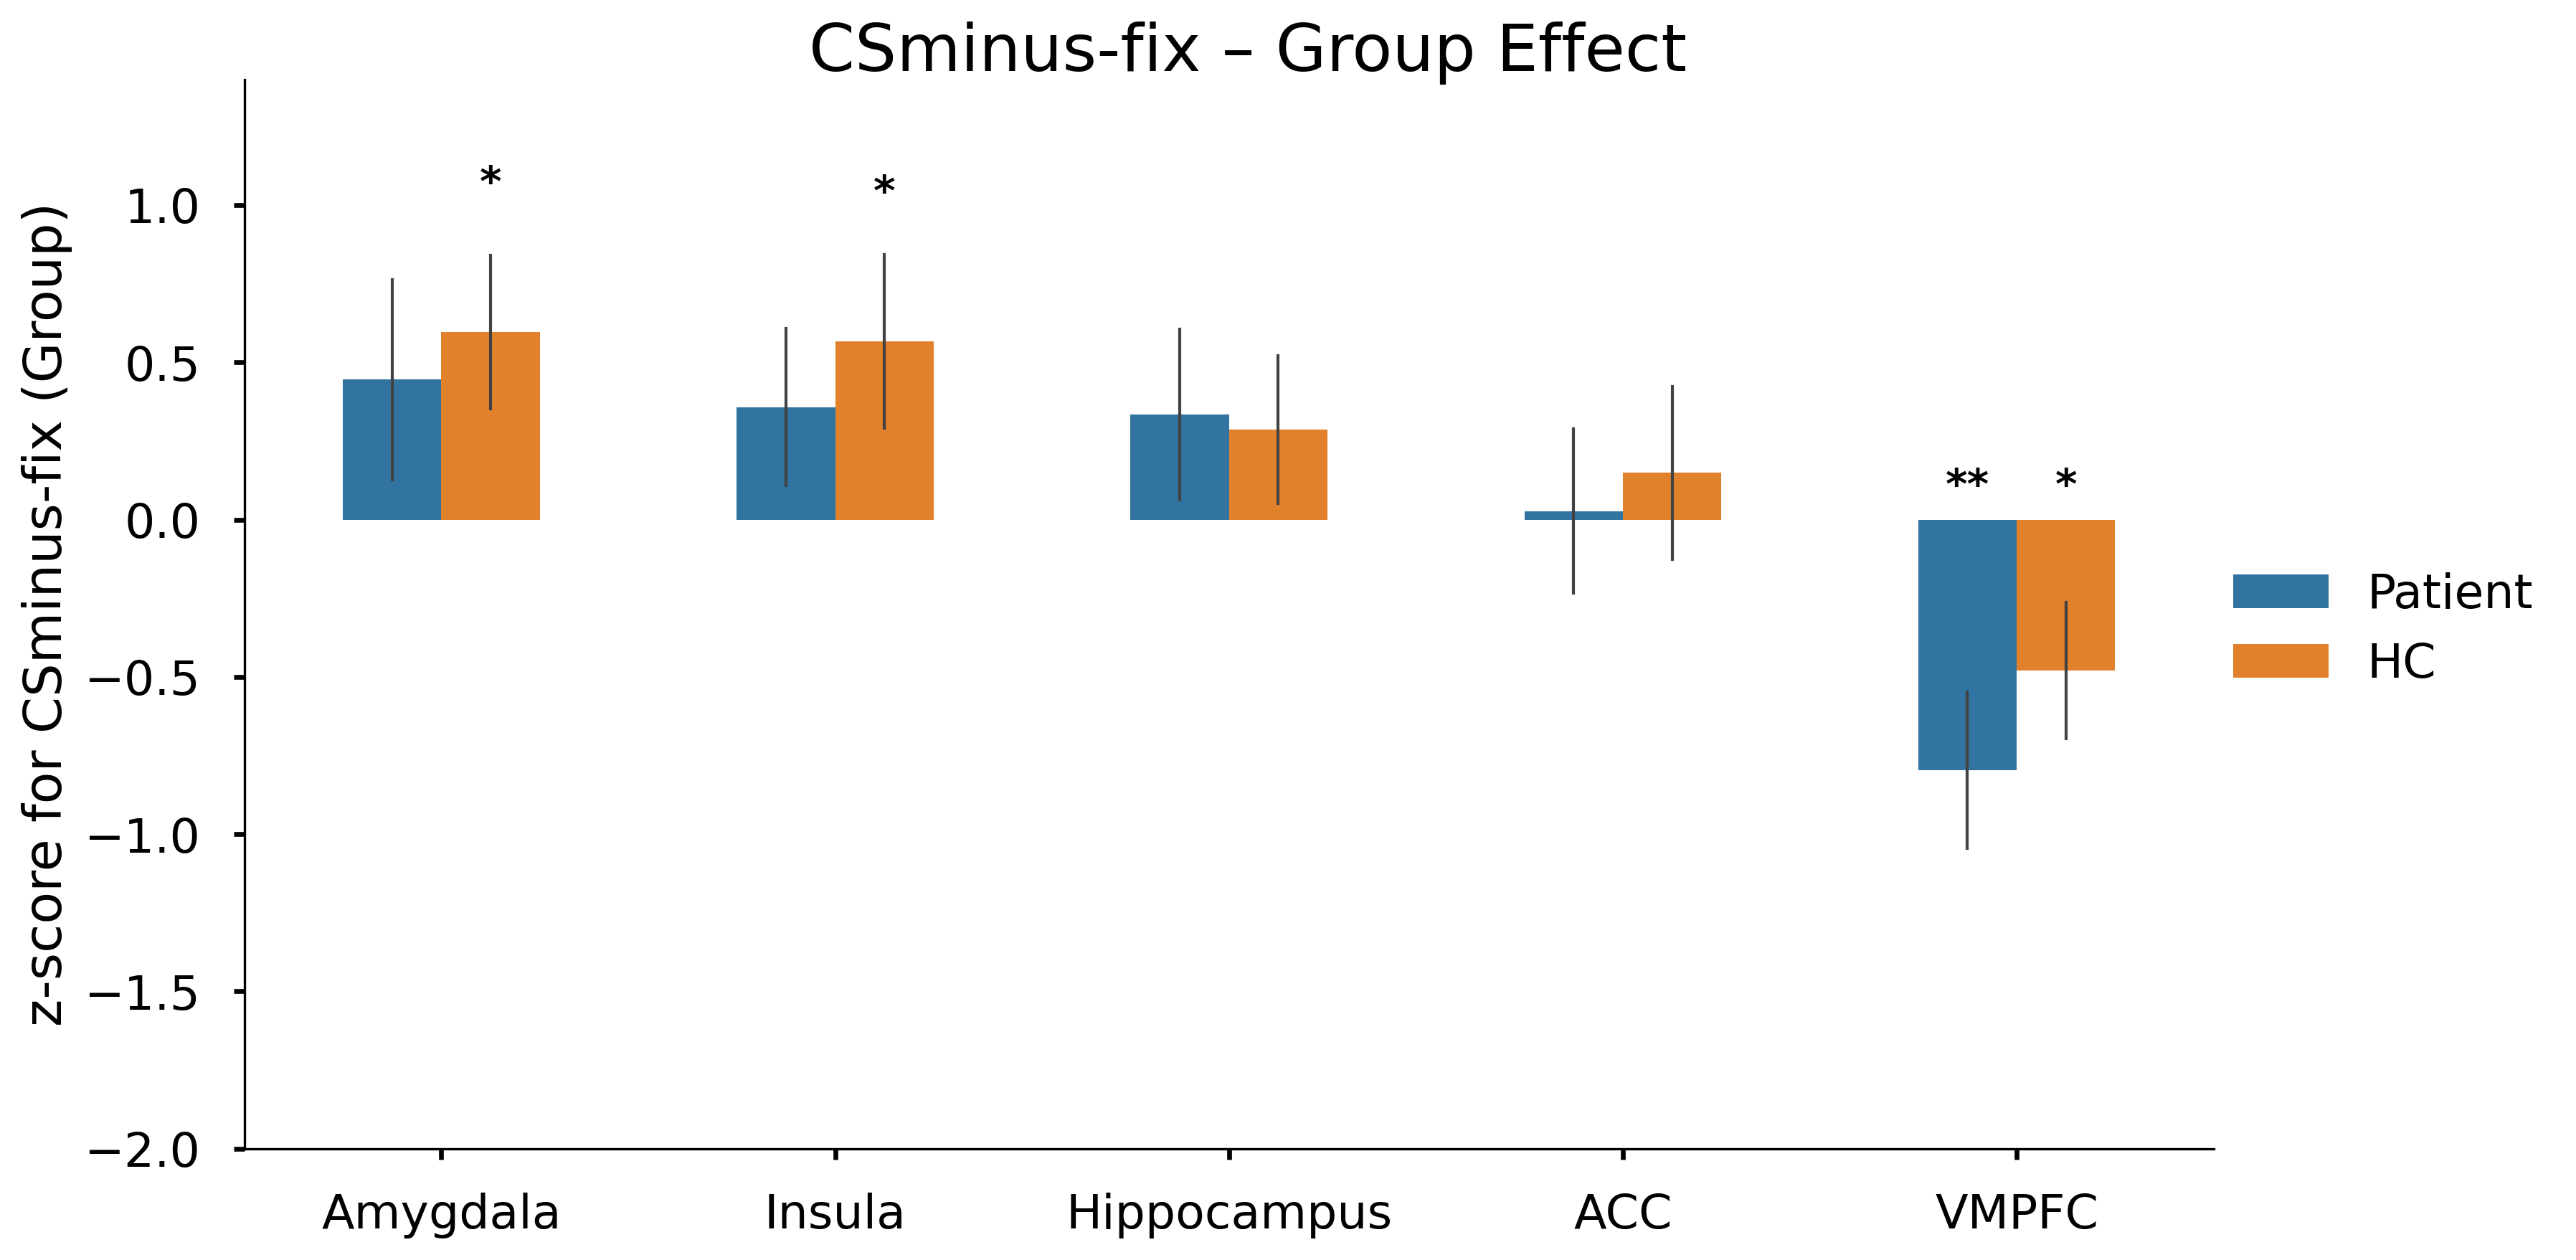

In [10]:
# 1️⃣ Group main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Group main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase3')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Group',
        order=ROI_list, hue_order=group_list,
        kind='bar', errorbar='se', 
        height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Group")[0], hue_order=group_list)


    g.set_axis_labels('', f'z-score for {contrast} (Group)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Group Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Group_sig.png', bbox_inches='tight')
    plt.show()


===== Gender main effect: CSR-CSS =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.331    -1.39    98    0.168      
Insula          Gender[T.Female]                                       -0.068    -0.25    98    0.800      
Hippocampus     Gender[T.Female]                                       -0.356    -1.40    98    0.164      
ACC             Gender[T.Female]                                       -0.170    -0.65    98    0.514      
VMPFC           Gender[T.Female]                                        0.090     0.34    98    0.732      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           


===== Gender main effect: CSR-CS- =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.394    -1.50    98    0.137      
Insula          Gender[T.Female]                                       -0.261    -0.93    98    0.353      
Hippocampus     Gender[T.Female]                                       -0.319    -1.23    98    0.221      
ACC             Gender[T.Female]                                       -0.135    -0.48    98    0.633      
VMPFC           Gender[T.Female]                                        0.178     0.66    98    0.510      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           


===== Gender main effect: CSS-CS- =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.066    -0.26    98    0.799      
Insula          Gender[T.Female]                                       -0.190    -0.80    98    0.425      
Hippocampus     Gender[T.Female]                                        0.018     0.07    98    0.943      
ACC             Gender[T.Female]                                        0.021     0.08    98    0.938      
VMPFC           Gender[T.Female]                                        0.090     0.36    98    0.718      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           


===== Gender main effect: CSR-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.227    -0.75    98    0.456      
Insula          Gender[T.Female]                                       -0.254    -0.81    98    0.420      
Hippocampus     Gender[T.Female]                                       -0.270    -0.95    98    0.343      
ACC             Gender[T.Female]                                       -0.644    -2.25    98    0.027     *
VMPFC           Gender[T.Female]                                        0.067     0.25    98    0.803      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

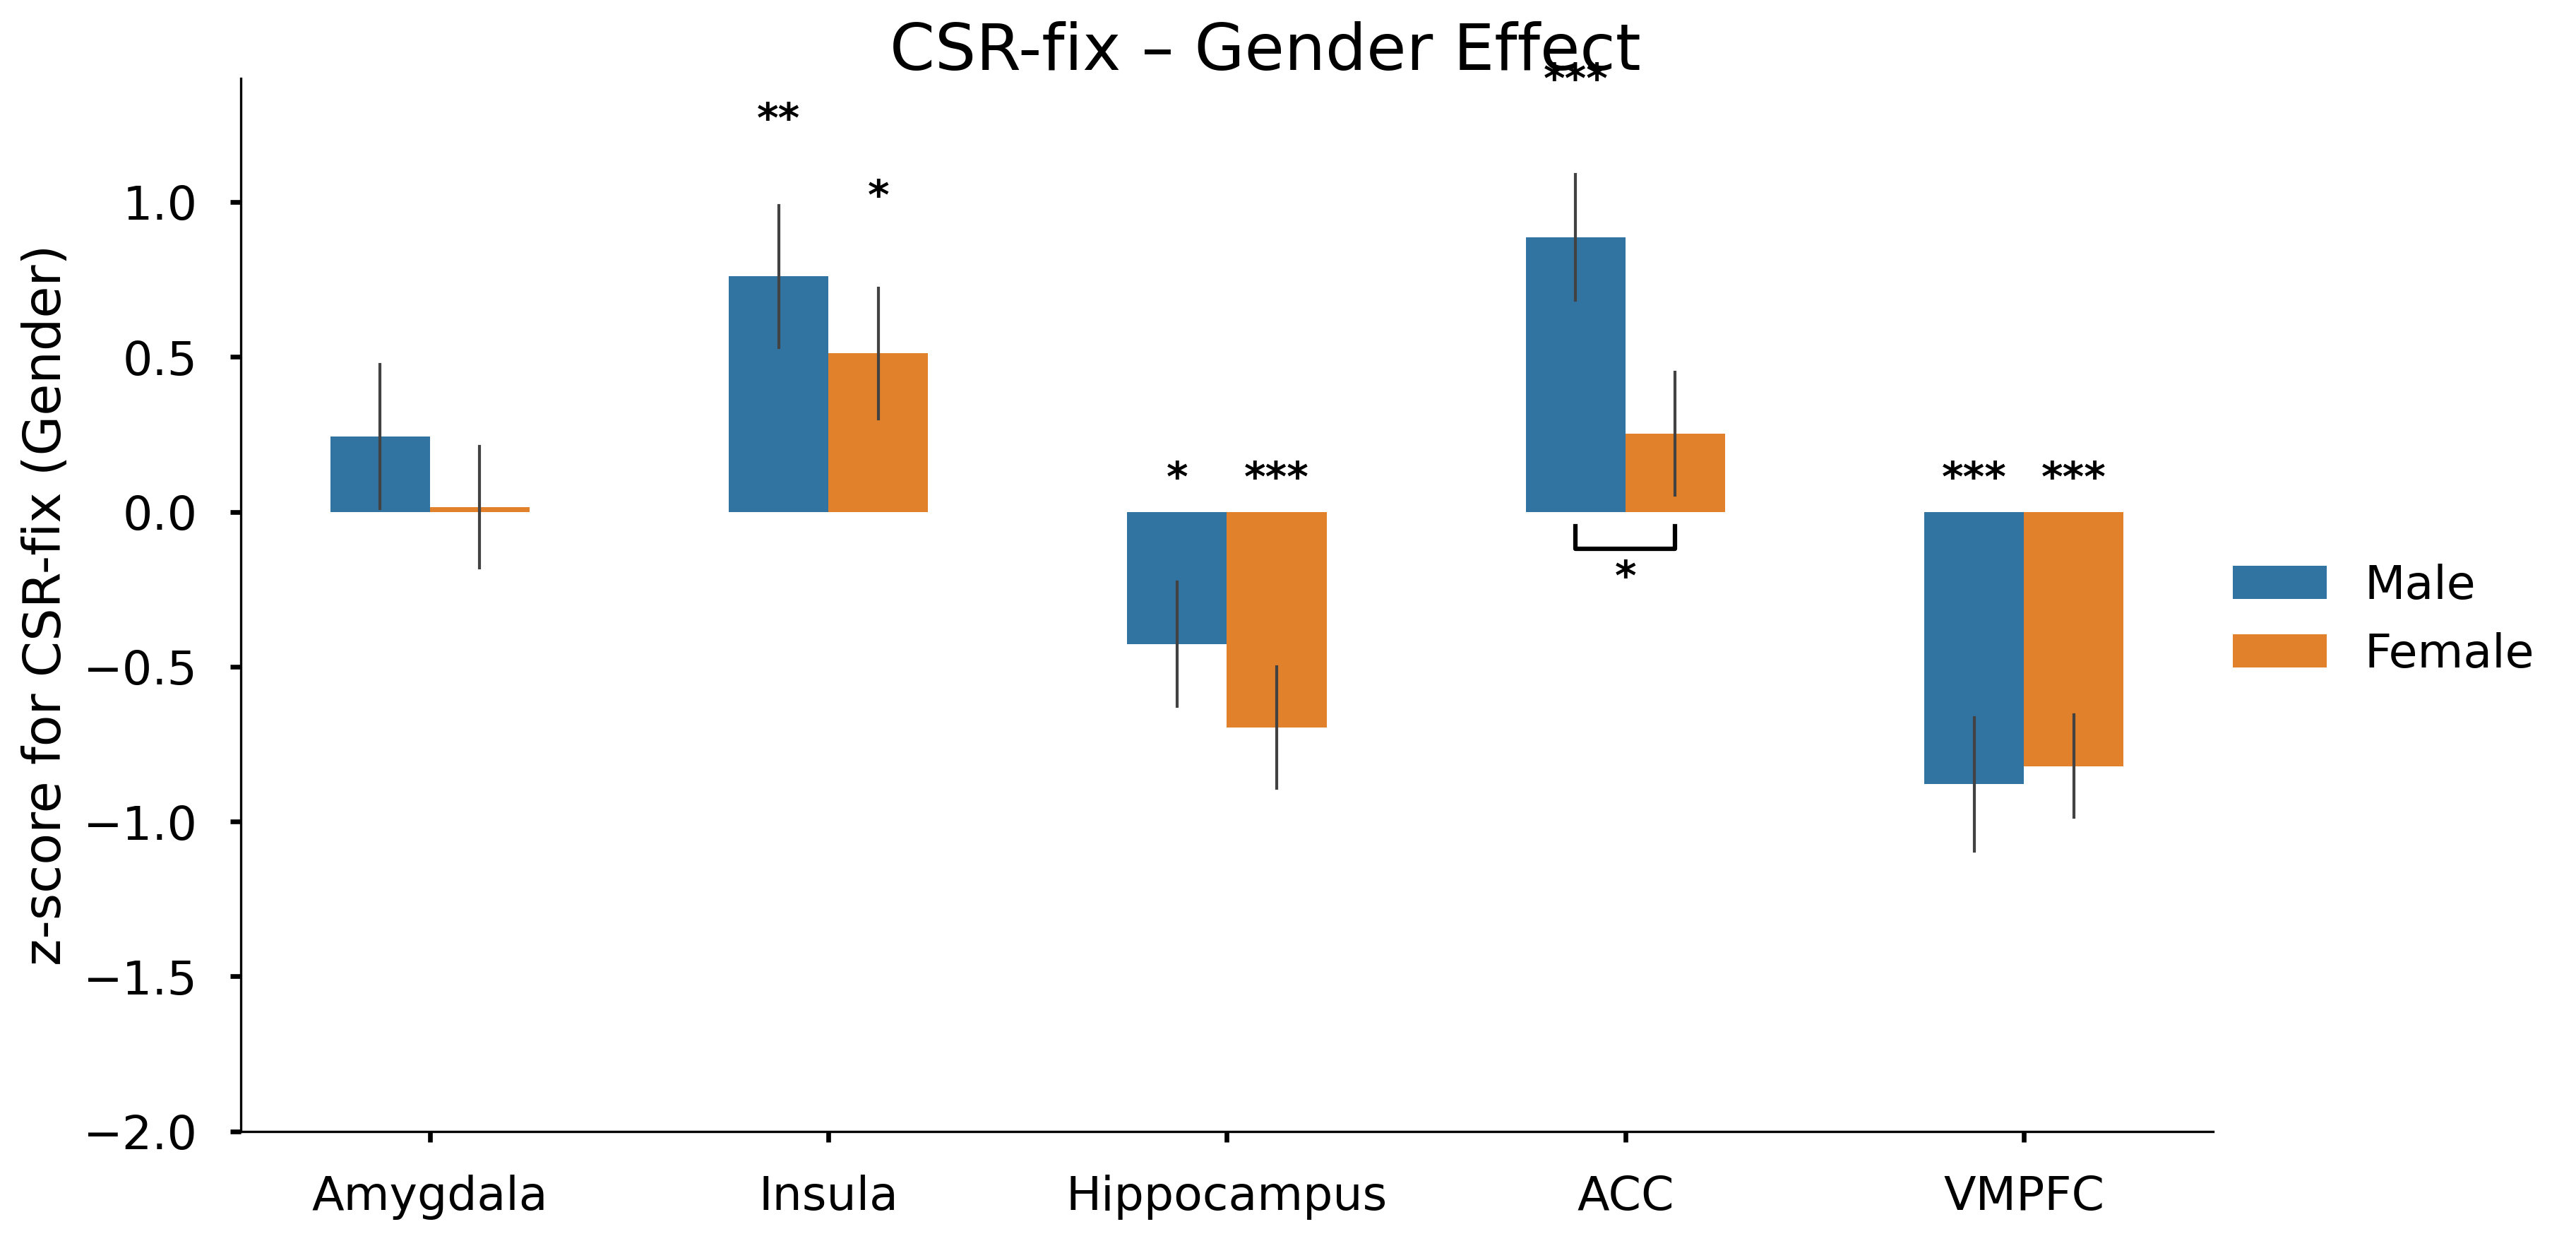


===== Gender main effect: CSS-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.197     0.69    98    0.491      
Insula          Gender[T.Female]                                       -0.163    -0.67    98    0.506      
Hippocampus     Gender[T.Female]                                        0.183     0.65    98    0.519      
ACC             Gender[T.Female]                                       -0.434    -1.54    98    0.126      
VMPFC           Gender[T.Female]                                       -0.044    -0.16    98    0.875      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           


===== Gender main effect: CSminus-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.269     0.95    98    0.345      
Insula          Gender[T.Female]                                        0.089     0.33    98    0.739      
Hippocampus     Gender[T.Female]                                        0.151     0.53    98    0.597      
ACC             Gender[T.Female]                                       -0.445    -1.68    98    0.097      
VMPFC           Gender[T.Female]                                       -0.159    -0.65    98    0.515      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level       

In [11]:
# ---------------------------------------------------------
# 3️⃣ Gender main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Gender main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Phase'] == 'phase3')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Gender',
        order=ROI_list, kind='bar', errorbar='se', height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Gender")[0])

    g.set_axis_labels('', f'z-score for {contrast} (Gender)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Gender Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Gender_sig.png', bbox_inches='tight')
    plt.show()


===== Group × Gender interaction: CSR-CSS =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.674     1.38    96    0.171      
Insula          Group[T.HC]:Gender[T.Female]                            0.245     0.44    96    0.662      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.376     0.71    96    0.477      
ACC             Group[T.HC]:Gender[T.Female]                           -0.189    -0.35    96    0.724      
VMPFC           Group[T.HC]:Gender[T.Female]                           -0.342    -0.64    96    0.525      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

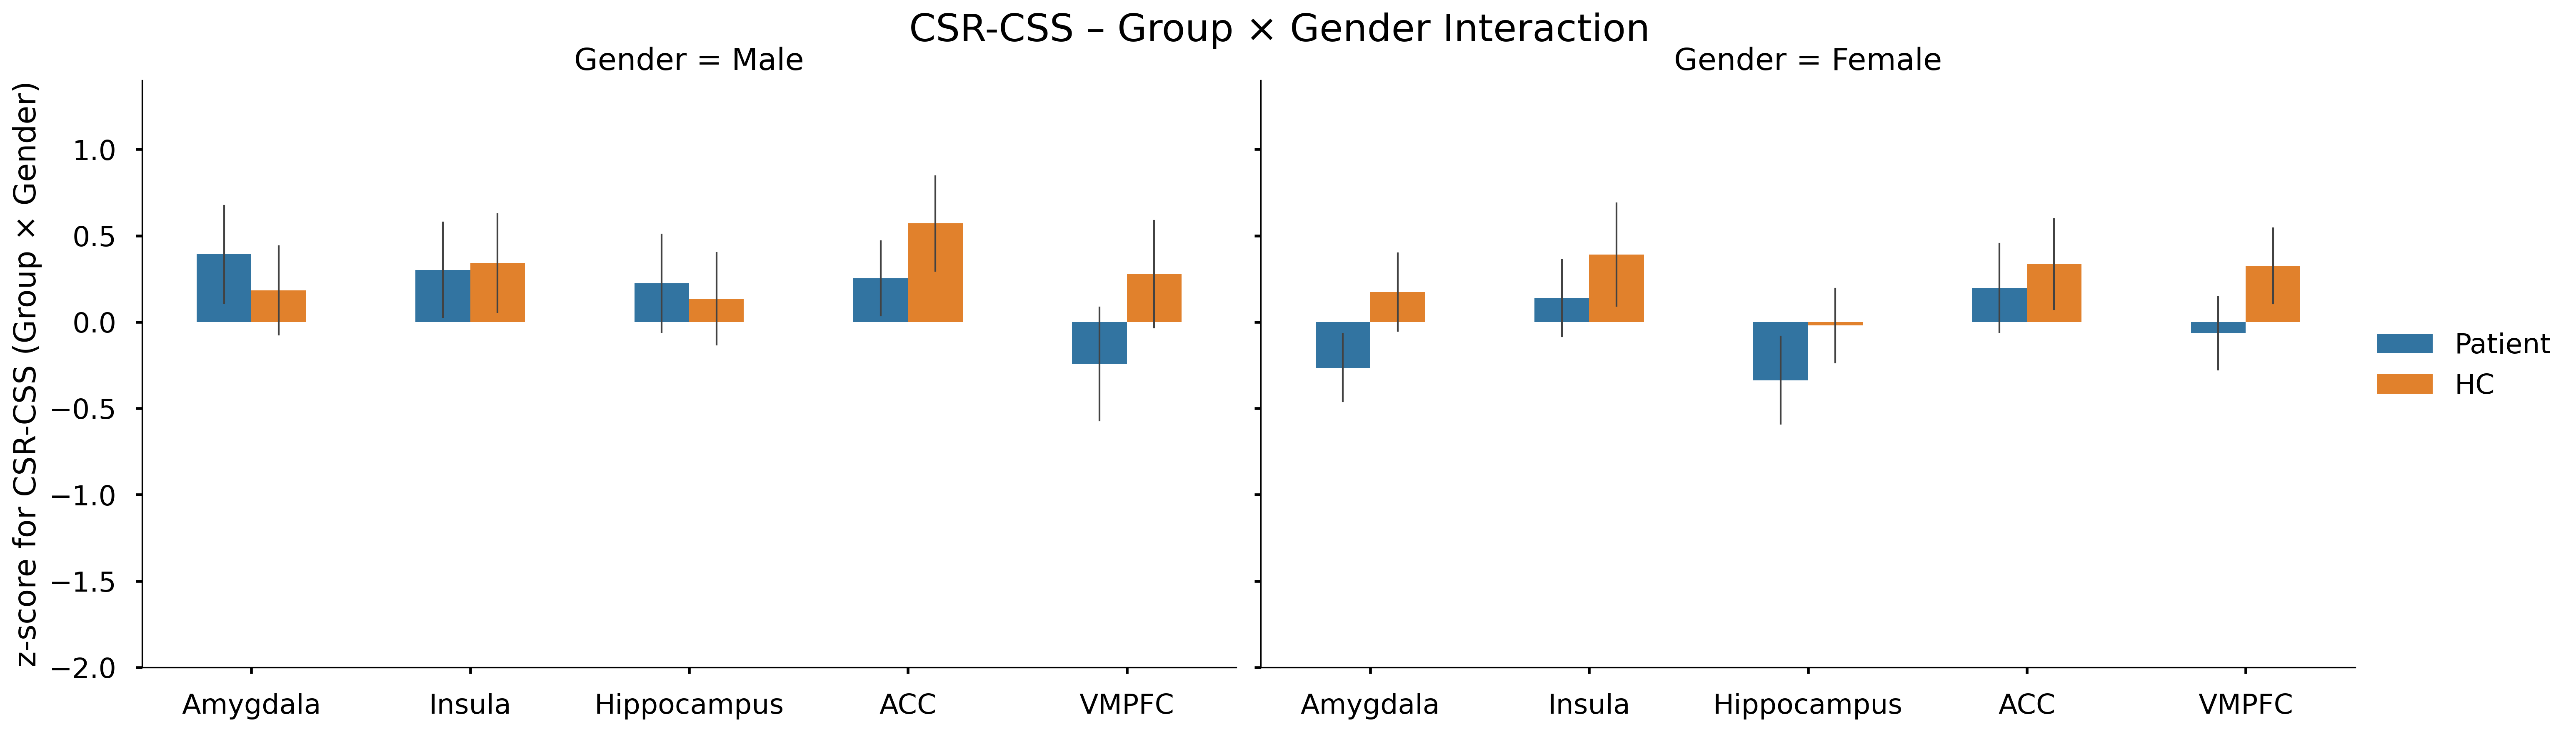


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.1713      
Insula              0.6617      
Hippocampus         0.4767      
ACC                 0.7243      
VMPFC               0.5245      
-----------------------------------



===== Group × Gender interaction: CSR-CS- =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.908     1.69    96    0.094      
Insula          Group[T.HC]:Gender[T.Female]                            0.803     1.40    96    0.164      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.723     1.36    96    0.178      
ACC             Group[T.HC]:Gender[T.Female]                            0.747     1.30    96    0.196      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.718     1.30    96    0.197      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

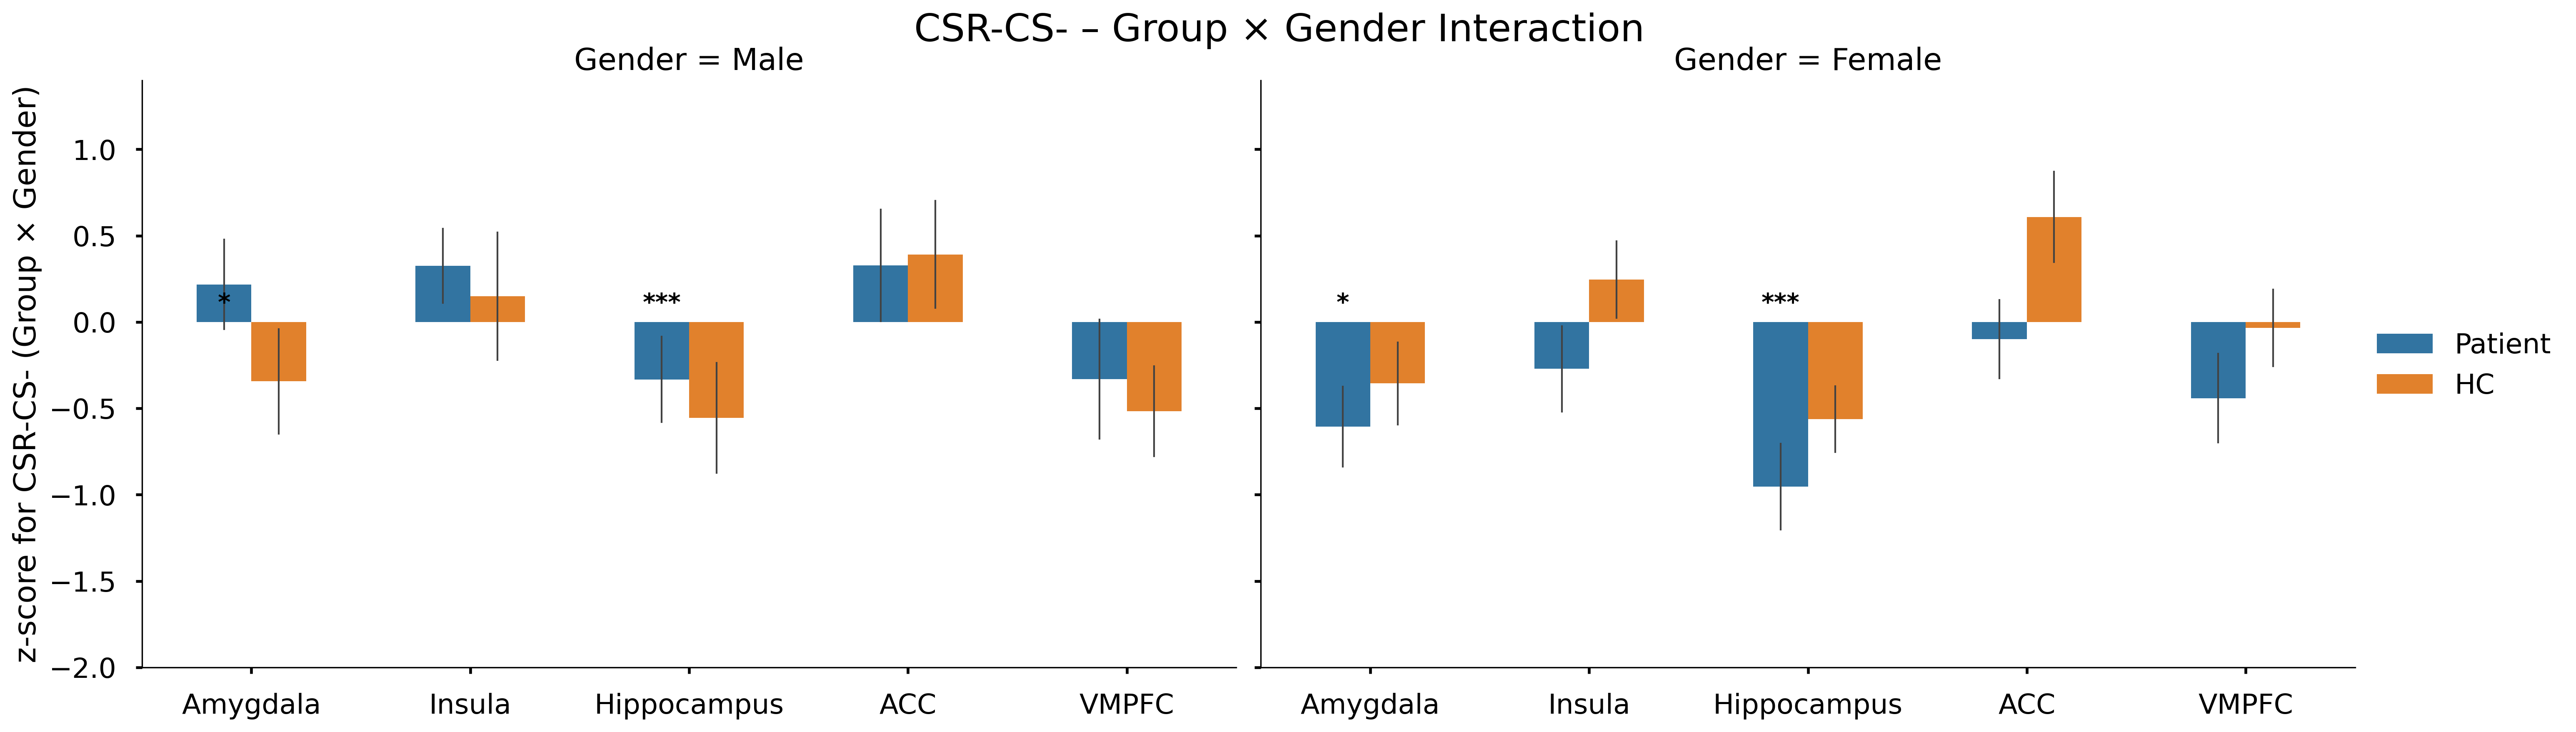


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.0944      
Insula              0.1642      
Hippocampus         0.1784      
ACC                 0.1961      
VMPFC               0.1975      
-----------------------------------


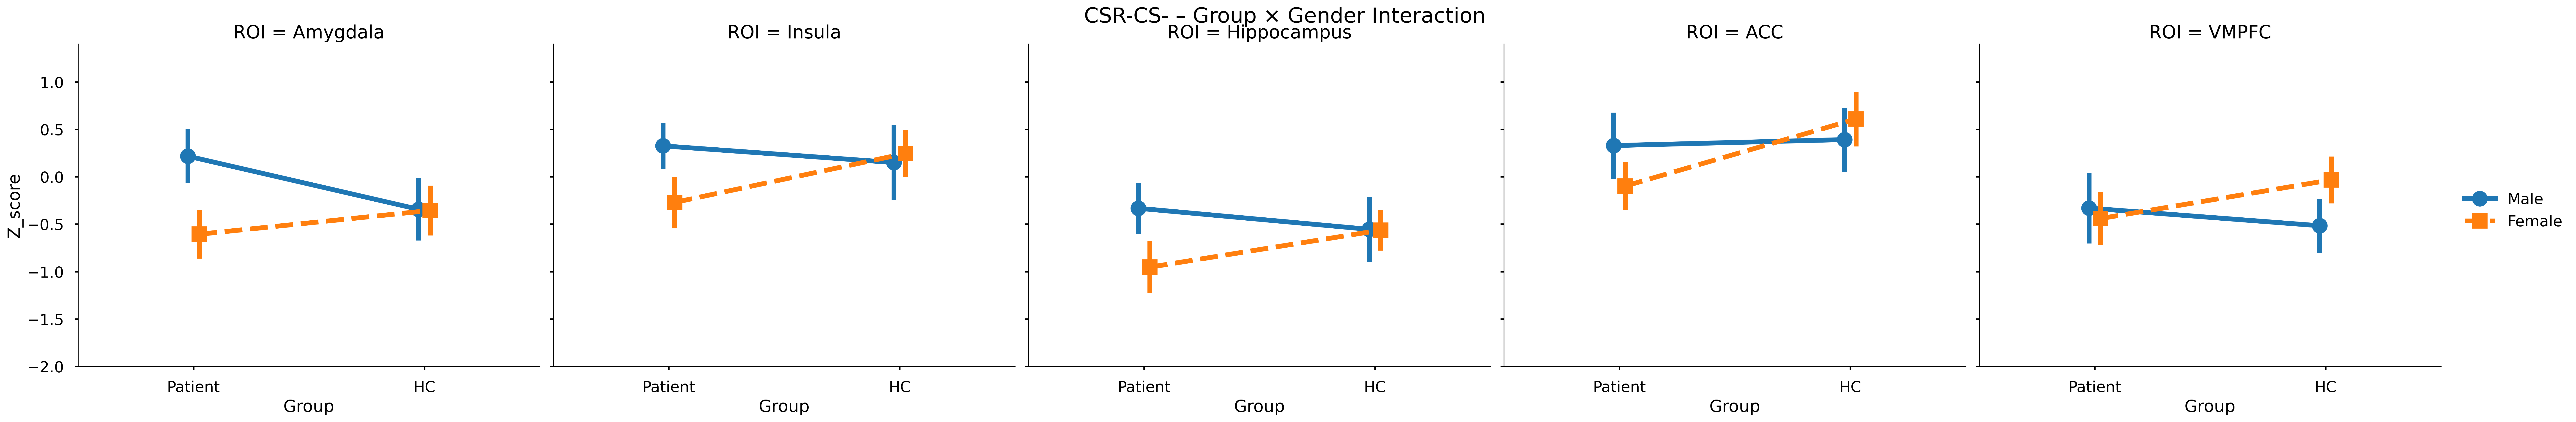


===== Group × Gender interaction: CSS-CS- =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.243     0.45    96    0.652      
Insula          Group[T.HC]:Gender[T.Female]                            0.546     1.12    96    0.267      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.344     0.67    96    0.506      
ACC             Group[T.HC]:Gender[T.Female]                            0.918     1.63    96    0.106      
VMPFC           Group[T.HC]:Gender[T.Female]                            1.056     2.11    96    0.038     *
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

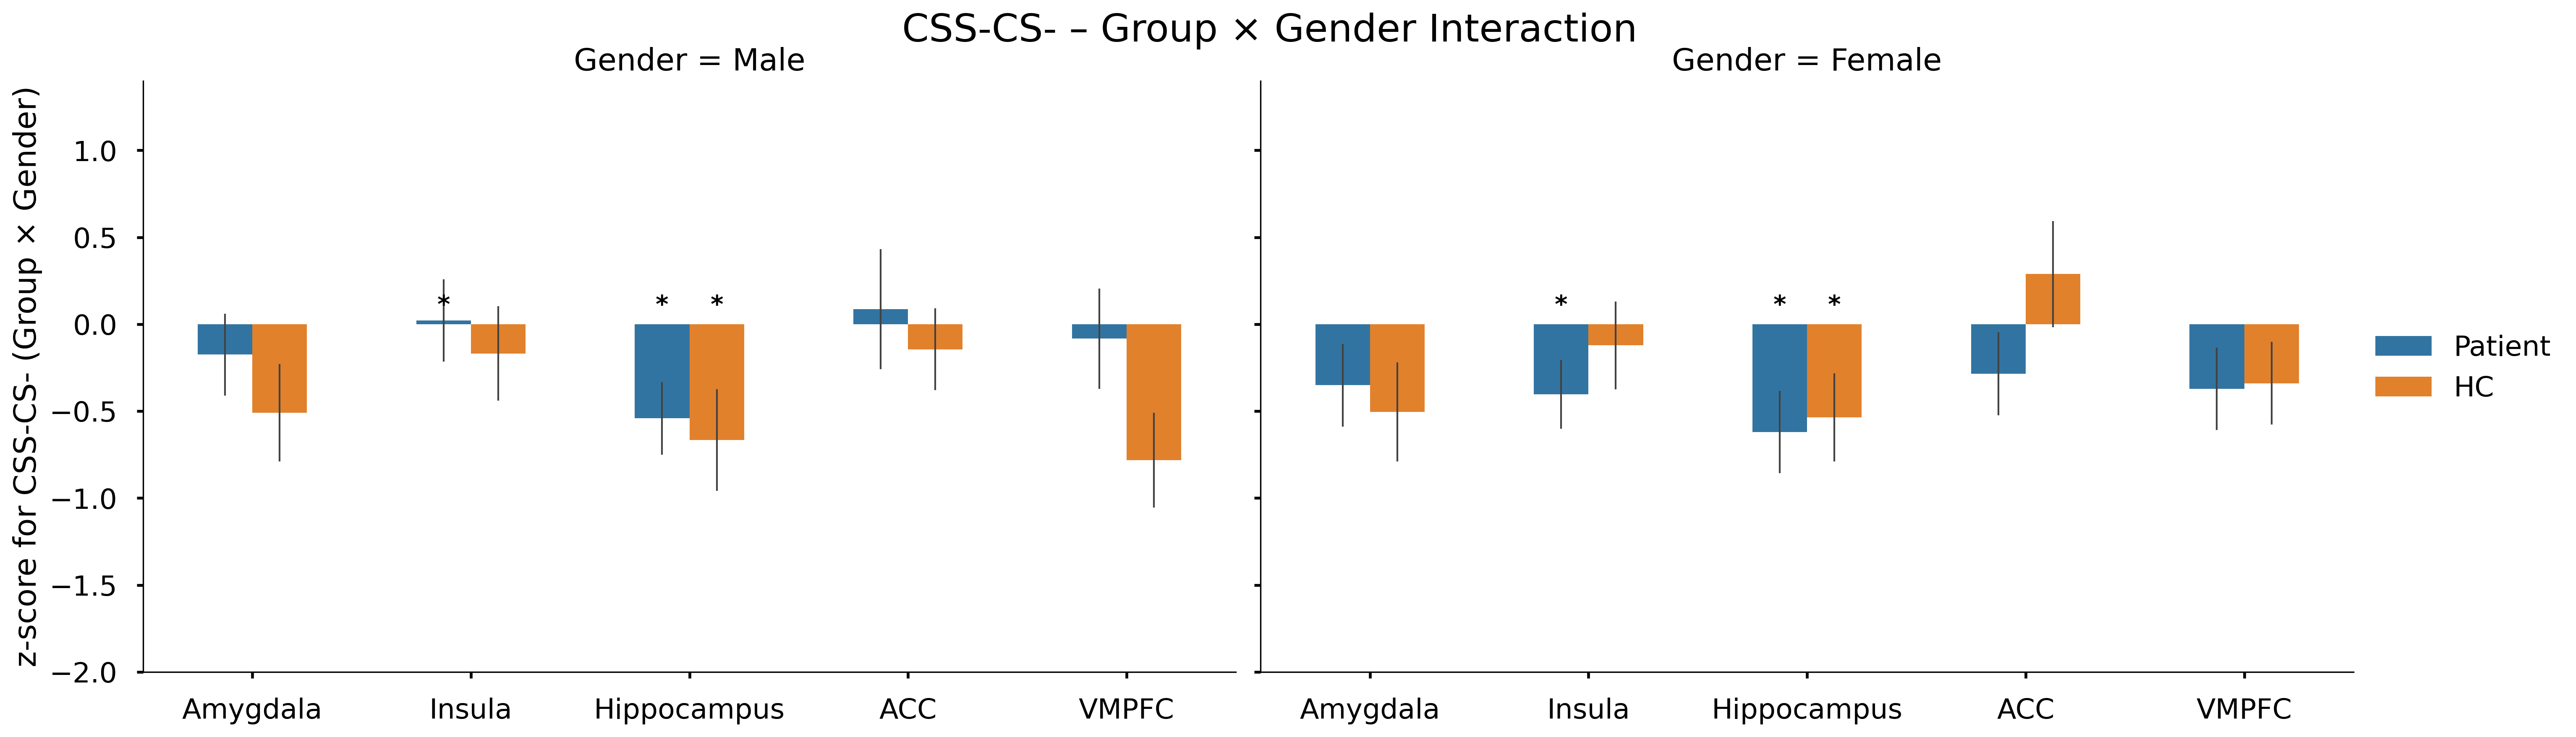


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.6517      
Insula              0.2669      
Hippocampus         0.5063      
ACC                 0.1059      
VMPFC               0.0377     *
-----------------------------------


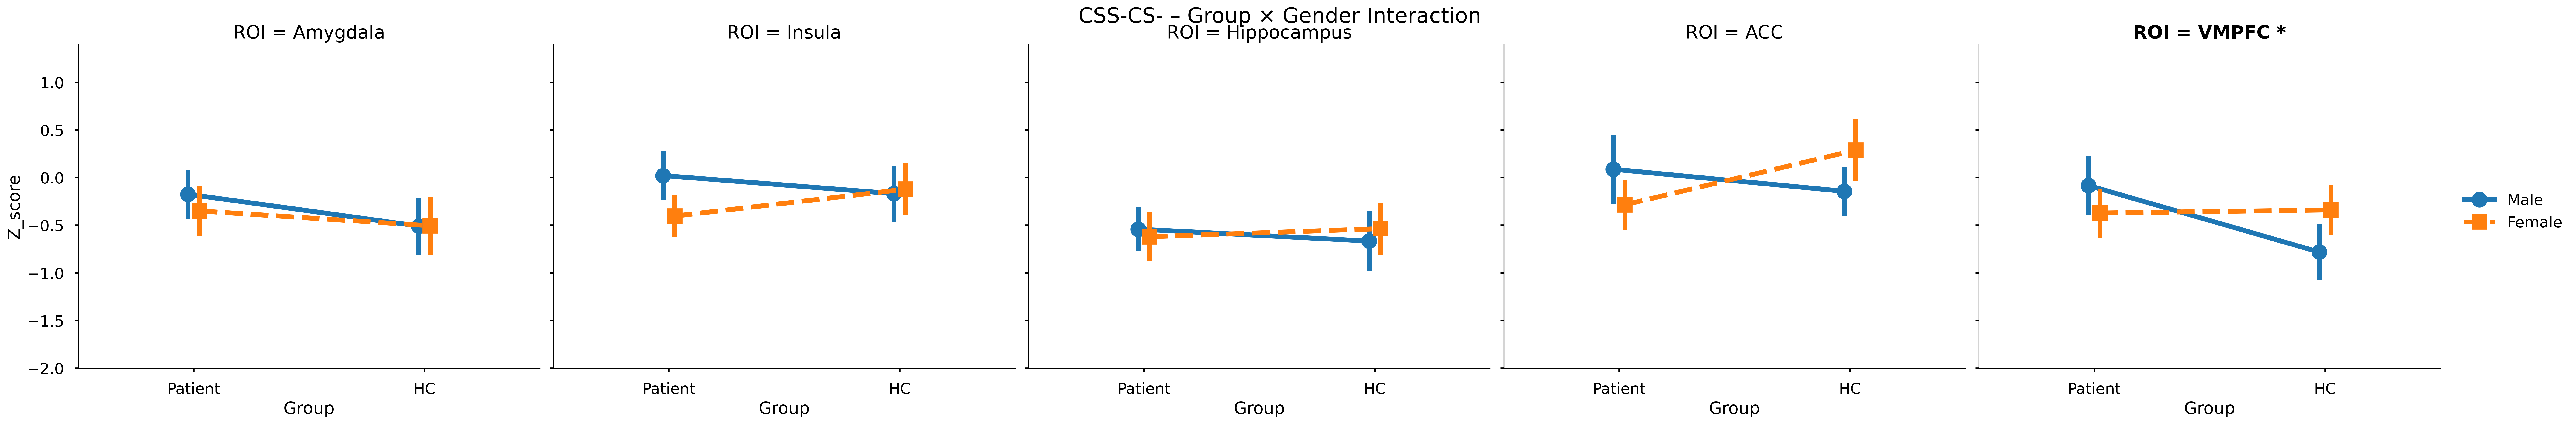


===== Group × Gender interaction: CSR-fix =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            1.385     2.26    96    0.026     *
Insula          Group[T.HC]:Gender[T.Female]                            0.811     1.26    96    0.211      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.981     1.69    96    0.095      
ACC             Group[T.HC]:Gender[T.Female]                            0.603     1.02    96    0.309      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.635     1.15    96    0.252      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

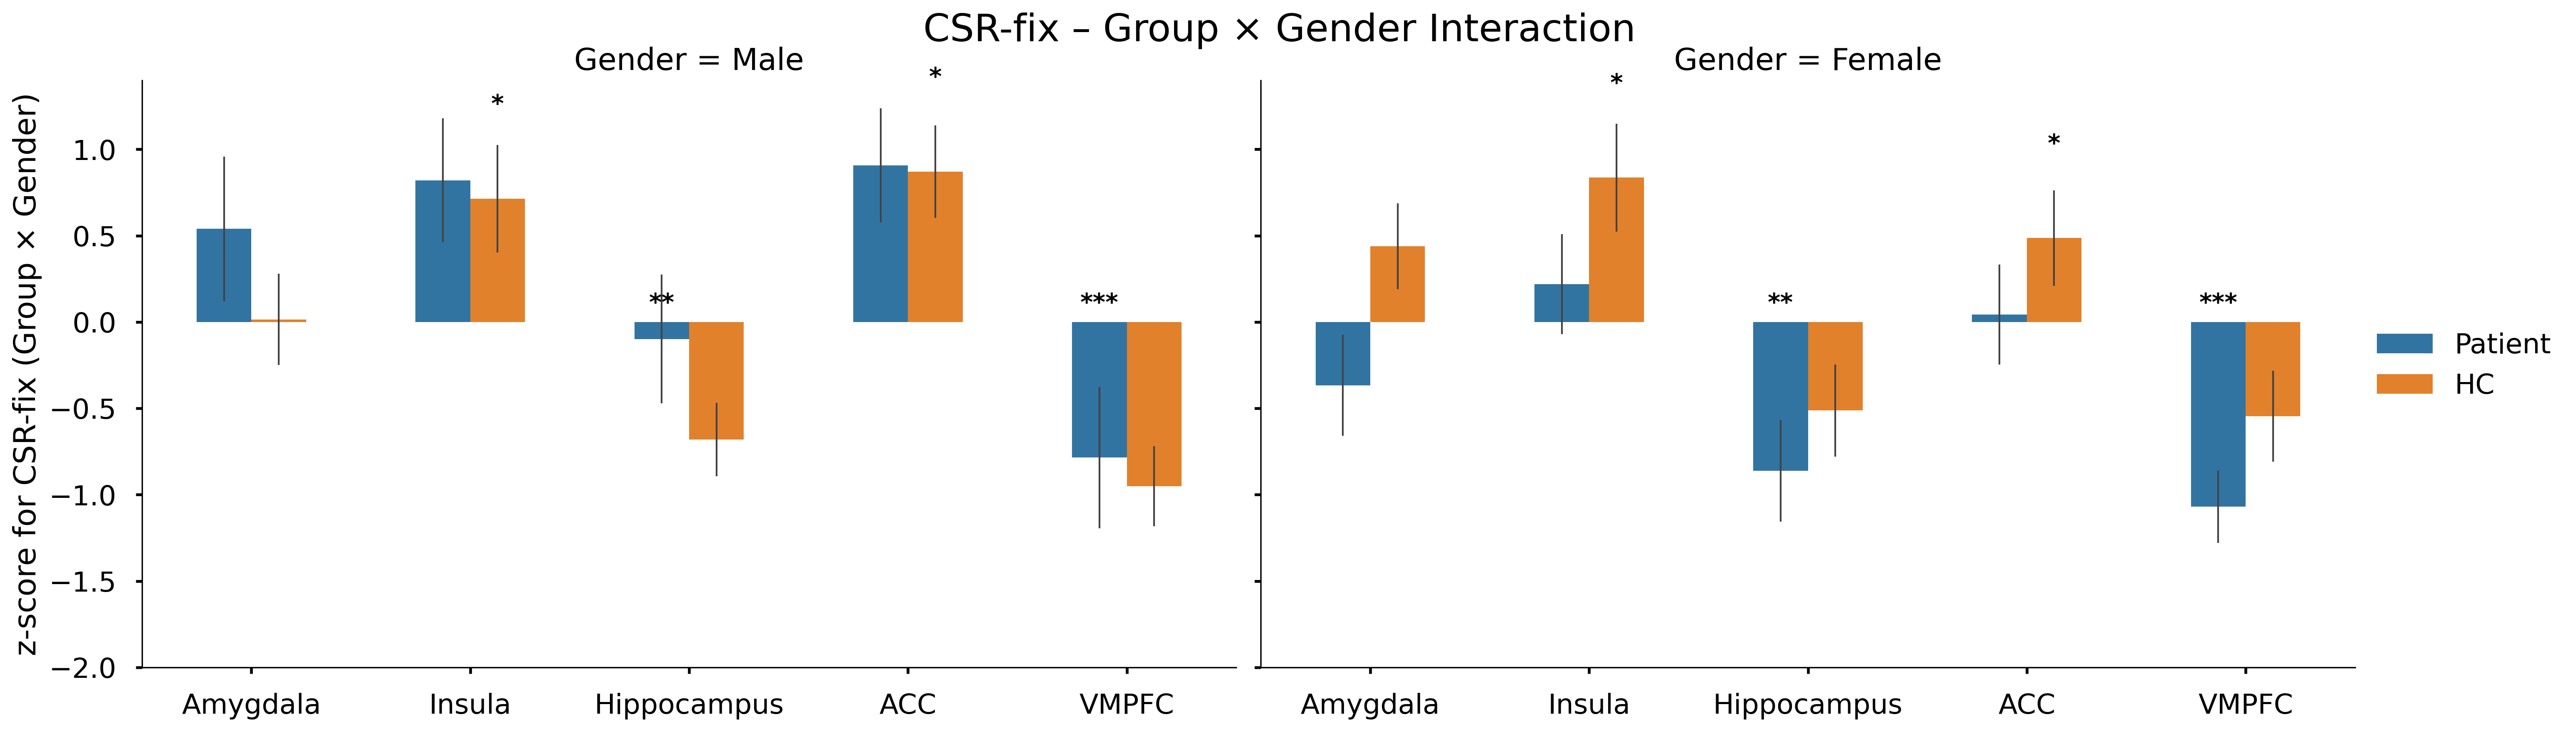


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.0263     *
Insula              0.2107      
Hippocampus         0.0945      
ACC                 0.3091      
VMPFC               0.2523      
-----------------------------------



===== Group × Gender interaction: CSS-fix =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.507     0.86    96    0.394      
Insula          Group[T.HC]:Gender[T.Female]                            0.484     0.96    96    0.340      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.480     0.82    96    0.412      
ACC             Group[T.HC]:Gender[T.Female]                            0.828     1.43    96    0.155      
VMPFC           Group[T.HC]:Gender[T.Female]                            1.077     1.92    96    0.058      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.3937      
Insula              0.3399      
Hippocampus         0.4118      
ACC                 0.1553      
VMPFC               0.0583      
-----------------------------------



===== Group × Gender interaction: CSminus-fix =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.174     0.30    96    0.767      
Insula          Group[T.HC]:Gender[T.Female]                           -0.253    -0.46    96    0.646      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.002     0.00    96    0.997      
ACC             Group[T.HC]:Gender[T.Female]                           -0.380    -0.70    96    0.488      
VMPFC           Group[T.HC]:Gender[T.Female]                           -0.344    -0.68    96    0.498      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group 


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.7670      
Insula              0.6458      
Hippocampus         0.9974      
ACC                 0.4885      
VMPFC               0.4980      
-----------------------------------


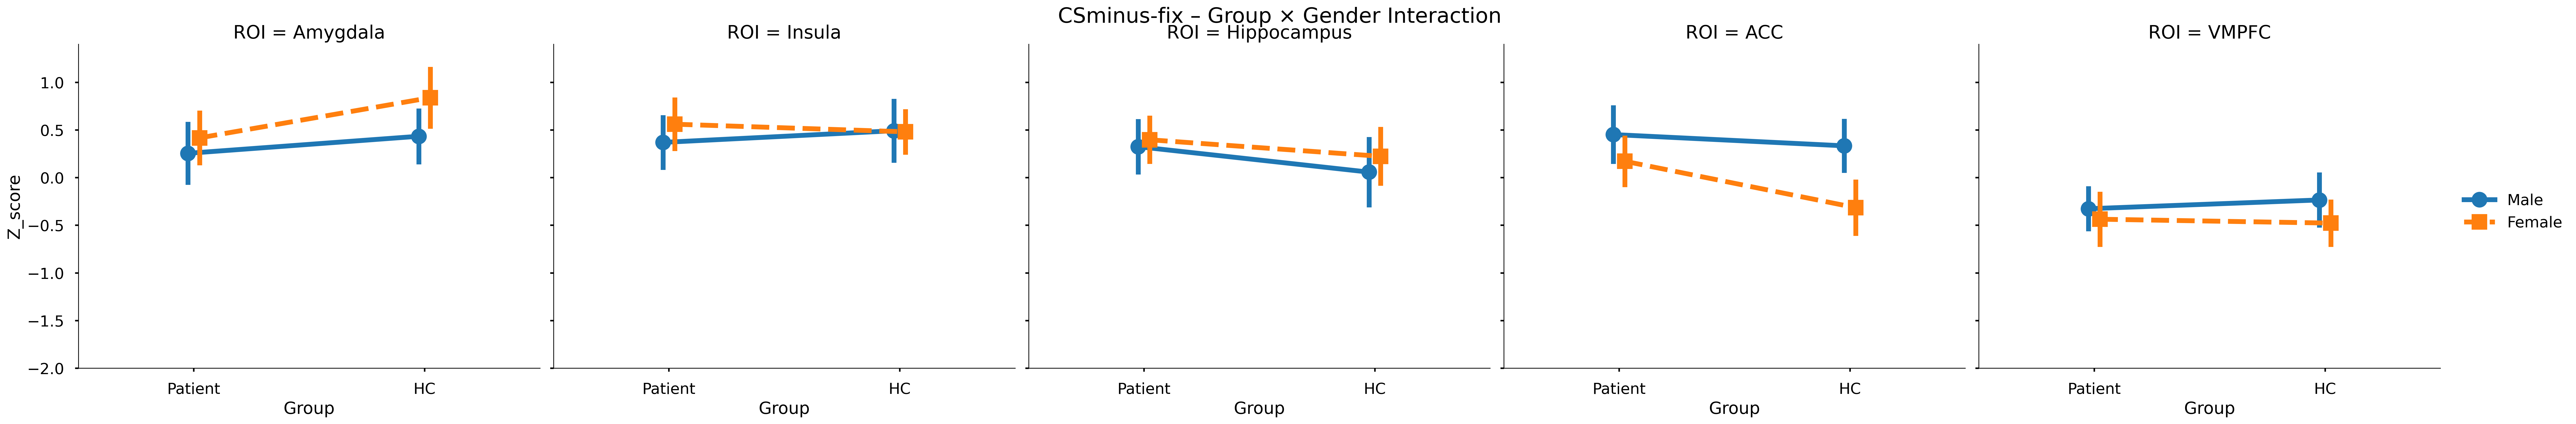

In [12]:
interaction_terms = get_matching_model_terms(model, "two_way")

for term in interaction_terms:
    var1, var2 = extract_factors_from_term(term)
    for contrast in contrast_list:
        print(f"\n===== {var1} × {var2} interaction: {contrast} =====")
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Phase'] == 'phase3')]

        g = sns.catplot(
            x='ROI', y='Z_score', hue=var1, col=var2,
            order=ROI_list,
            kind='bar', errorbar='se',
            height=6, aspect=1.6, width=0.5,
            err_kws={'linewidth': 1},
            data=df
        )

        for ax in g.axes.flat:
            add_sig_stars(ax, df, ROI_list, term)

        g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

        #line plots
        g = sns.catplot(
            data=df,
            x=var1, y='Z_score', hue=var2,
            col='ROI',
            kind='point',         # line plot (mean + SE)
            errorbar='se',        # ✅ correct for seaborn ≥0.12
            dodge=True,
            markers=['o', 's'],
            linestyles=['-', '--'],
            height=6, aspect=1.2
        )
        add_sig_stars_lineplot_interaction(
            g.axes, df, ROI_list, term
        )
        #g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/line_{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

In [13]:

formula = "Z_score ~ Group * Gender + guess"

for contrast in contrast_list:
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Phase'] == 'phase3')]

        print(f"\nModel results ({formula}) in {contrast}")
        print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
        print("-" * 100)

        # === Table 1: Model results ===
        for i, roi in enumerate(ROI_list):
            df_roi = df[df["ROI"] == roi]
            if len(df_roi) < 4:
                continue
            model = smf.ols(formula, data=df_roi).fit()
            dfree = int(model.df_resid)

            # Extract and print all terms except intercept
            for term in model.params.index:
                if term.lower() == "intercept":
                    continue

                beta = model.params[term]
                tval = model.tvalues[term]
                pval = model.pvalues[term]
                star = significance_marker(pval)

                print(f"{roi:<15} {term:<50} {beta:>10.3f} {tval:>8.2f} "
                    f"{dfree:>5} {pval:>10.4f} {star:>5}")

        print("-" * 100)
    


Model results (Z_score ~ Group * Gender + guess) in CSR-CSS
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.221    -0.62    96     0.5367      
Amygdala        Gender[T.Female]                                       -0.673    -1.92    96     0.0584      
Amygdala        guess[T.1.0]                                           -0.063    -0.25    96     0.8033      
Amygdala        Group[T.HC]:Gender[T.Female]                            0.674     1.38    96     0.1713      
Insula          Group[T.HC]                                             0.024     0.06    96     0.9530      
Insula          Gender[T.Female]                                       -0.184    -0.46    96     0.6488      
Insula          guess[T.1.0]                                          